(20, 2)
(20, 1)
(20, 3)
(13, 5, 2) (13, 3)
2
Current Time = 05:57:23
Current Time = 05:57:45
[[[0.63360705 1.26721409]
  [0.67487039 1.34974077]
  [0.71358728 1.42717457]
  [0.74940568 1.49881137]
  [0.78211243 1.56422486]]]
Current Time = 05:57:47
[170.00000358 180.00000403 190.00000458]
[169.9237  186.25449 191.77075]


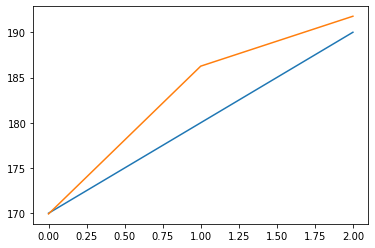

RMSE: 14.086637757993024 MAPE: 1.4838551157197497


In [30]:
# multivariate multi-step stacked lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Layer
from numpy import array
from numpy import hstack
from keras.layers import *
from keras.models import *
from keras import backend as K
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from sklearn.preprocessing import PowerTransformer
import pandas as pd
from sklearn.preprocessing import StandardScaler

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape


power = PowerTransformer(method='yeo-johnson')
 
# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
 
    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context
    
def stable_sigmoid(x):
    sig = np.where(x < 0, np.exp(x)/(1 + np.exp(x)), 1/(1 + np.exp(-x)))
    return sig

def inverse_sigmoid(x):
    inv_sig = -np.log((1 / (x + 1e-8)) - 1)
    return inv_sig
    
# split a multivariate sequence into samples
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, 1:], sequences[end_ix-1:out_end_ix, 0][1:1+n_steps_out]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

in_seq = np.transpose(np.array([np.arange(0,200,10),np.arange(5,205,10)*100]))

#in_seq = np.transpose(np.transpose(np.array(data[set_])).reshape(len(set_),int(len(data[set_].values.ravel())/len(set_))))
print(in_seq.shape)

scaler = StandardScaler()

#ensuring scaling isn't extracted from test data
x_train = in_seq[:-1]
scaler.fit(x_train)
in_seq = scaler.transform(in_seq)
in_seq = stable_sigmoid(in_seq)

out_seq = np.sum(np.array(in_seq),axis=1)

out_seq = out_seq.reshape(len(out_seq), 1)

print(out_seq.shape)

dataset = hstack((in_seq,out_seq))
print(dataset.shape)

# choose a number of time steps
n_steps_in, n_steps_out = 5, 3
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)

#x_train = preprocessing.scale(dataset, with_mean=True, with_std=True)

print(X.shape, y.shape)
# summarize the data

"""
for i in range(len(X)):
	print(X[i], y[i])
"""

n_features = X.shape[2]
print(n_features)
# define model
model = Sequential()
model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=True), input_shape=(n_steps_in, n_features)))
model.add((LSTM(128, activation='tanh', return_sequences=True)))
model.add((LSTM(128, activation='tanh', return_sequences=True)))
#model.add(BatchNormalization())
model.add(attention(return_sequences=True)) #
model.add(Dropout(0.5))
model.add(Dense(n_steps_out))

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X[:-1], y[:-1], epochs=512, verbose=0,batch_size = 128)

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

# demonstrate prediction
x_input = X[-1]
x_input = x_input.reshape((1, n_steps_in, n_features))
print(x_input)
yhat = model.predict(x_input, verbose=0)

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

y_ = inverse_sigmoid(y[-1])*scaler.scale_[0]+scaler.mean_[0]
yhat = inverse_sigmoid(yhat)*scaler.scale_[0]+scaler.mean_[0]
print(y_)
print(*yhat)
plt.plot(y_)
plt.plot(*yhat)
plt.show()

rmse = mean_squared_error(y_, *yhat, squared=True)
print("RMSE:",rmse,"MAPE:",MAPE(y_, yhat))